# MPS, a basic 2D example

> **Note** this notebook is inspired from the notebook [ex_deesse_01_basics.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_01_basics.ipynb), by Julien Straubhaar.

This first example is to illustrate the main working principles of MPS. In particular, in this notebook we rely on the MPS algorithm named Direct Sampling ("DS", or "deesse"). 

As usual, import the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

## Import the training image

When using multiple-point statistics (MPS), there is no need for a variogram model. Indeed, the model of heterogeneity is represented by the training image (TI).

Here the training image is contained in the file `ti.txt`, and can be read using the function `geone.img.readImageTxt`. You can also open the file with any text editor to check how it is formatted.

In [2]:
ti = gn.img.readImageTxt("ti.txt")
# Print out the TI, to get some info about it.
ti

*** Img object ***
name = 'ti.txt'
(nx, ny, nz) = (300, 250, 1) # number of cells along each axis
(sx, sy, sz) = (1.0, 1.0, 1.0) # cell size (spacing) along each axis
(ox, oy, oz) = (0.0, 0.0, 0.0) # origin (coordinates of bottom-lower-left corner)
nv = 1  # number of variable(s)
varname = ['code']
val: (1, 1, 250, 300)-array
*****

It is also useful to check the content of the input TI, like for example the number of unique values that are defined.

In [3]:
ti.get_unique()

array([0., 1., 2.])

## Plot the input TI

The input TI can be plotted using the function `geone.imgplot.drawImage2D`.

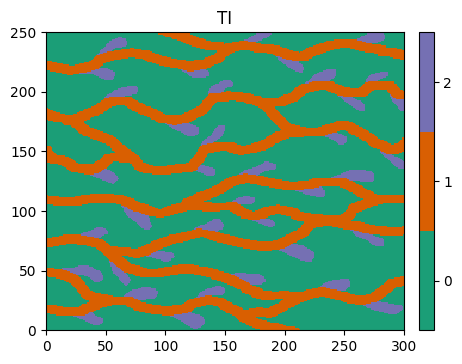

In [4]:
# Define category values and colors
categ_val = [0, 1, 2]
categ_col = ['#1b9e77', "#d95f02", '#7570b3']

# Plot
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col)
plt.title('TI')
plt.show()

## Simulation grid

The definition of a simulation grid is required, that is the number of cells in each direction, cell size and origin.

> **Note** In general, the size of the training image and the simulation grid can be different. The simulation grid can be smaller (like in this case) or bigger than the training image. The only constraint about the TI is that is should be big enough to contain a statistically meaningful number of patterns. Very often it is also required *stationarity*. However, there are techniques that allow to handle non stationary training images too. 

In [5]:
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Hard data (point set)

Conditioning (hard data) can be defined in the script, or most often they are read from an external file (in this case, the file `hd.txt`) using the function `geone.img.readPointSetTxt` (see jupyter notebook [ex_a_01_image_and_pointset.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_a_01_image_and_pointset.ipynb) for details).

In [6]:
hd = gn.img.readPointSetTxt('hd.txt')
hd

*** PointSet object ***
name = ''
npt = 7 # number of point(s)
nv = 4  # number of variable(s) (including coordinates)
varname = ['X', 'Y', 'Z', 'code']
val: (4, 7)-array
*****

We can also print the read content

In [7]:
hd.val

array([[10.5, 14.5, 60.5, 45.5, 17.5, 52.5, 45.5],
       [20.5, 21.5, 32.5, 55.5, 75.5, 80.5, 97.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 2. ,  2. ,  1. ,  0. ,  1. ,  0. ,  0. ]])

The array `hd.val` contains:
- `hd.val[0]`: $x$ coordinates of the points
- `hd.val[1]`: $y$ coordinates of the points
- `hd.val[2]`: $z$ coordinates of the points
- `hd.val[3]`: value of the variable

## Plot the hard data

Plot the hard data points in the simulation grid.

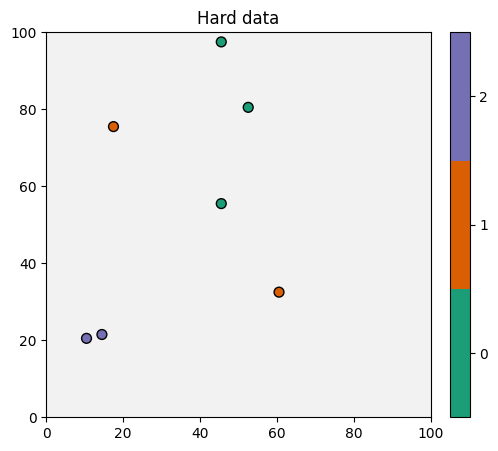

In [8]:
# Get the colors for values of the variable of index 3 in the point set, 
# according to the color settings used for the TI
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categ_val, categCol=categ_col)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.figure(figsize=(8,5))

# Plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, categ=True, categVal=categ_val, categCol=categ_col)

# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', linewidths=1)

plt.title('Hard data')
plt.show()

## DS input parameters

In the next section of code we define the input structure required for running the DS simulation.

The variable name for the hard data (in `hd.varname`) and for the simulated variable (keyword argument `varname` below) should be the same, otherwise, the hard data will be ignored. Moreover, the hard data locations should be in the simulation grid, which is described by its dimensions (number of cells) in each direction, the cell unit in each direction, and the origin (the *corner* of the grid cell with the minimal $x$, $y$, $z$ coordinates). Hard data points that lie outside of the simulation grid are ignored.  

The hard data can be passed to deesse through a *point set*, i.e. a class `geone.img.PointSet` (keyword argument `dataPointSet`, as below) or through an *image*, i.e. a class `geone.img.Img` (keyword argument `dataImage`, not illustrated here), and can contain missing (uninformed) data (`nan`).

The type of distance for computing the dissimilarity between patterns is controlled by the keyword argument `distanceType`: 
- `0` or `'categorical'`: proportion of non-matching nodes (default)
- `1` or `'continuous'`: $L_1$ distance
- `2`: $L_2$ distance
- `3`: $L_p$ distance (requires real positive parameter p given in parameter `powerLpDistance`)
- `4` :$L_\infty$ distance

In [9]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid
    nv=1, varname='code',       # number of variable(s), name of the variable(s)
    TI=ti,                      # TI (class gn.deesseinterface.Img)
    dataPointSet=hd,            # hard data (optional)
    distanceType='categorical', # distance type: proportion of mismatching nodes (categorical var., default)
    #conditioningWeightFactor=10.,  # put more weight to conditioning data (if needed)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.05,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=nreal)         # number of realization(s)

## Run the DS simulation

The function `geone.deesseinterface.deesseRun` launches the DS simulation. The code runs in parallel (using the library *OpenMP*). The number of threads used can be specified by the keyword argument `nthreads`. Specifying a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

In [10]:
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads=8)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
DeeSse run complete


## Retrieve the results and display

The function `geone.deesseinterface.deesseRun` (or `geone.deesseinterface.deesseRun_mp`) returns a dictionary in the variable `deesse_output` including the keys: `'sim'`, `'nwarnings'`, `'warnings'`.

The realizations are stored in `deesse_output['sim']`, a 1-dimensional array of *images* (class `geone.img.Img`) of size `deesse_input.nrealization`, `deesse_output['sim'][i]` being the i-th realization.

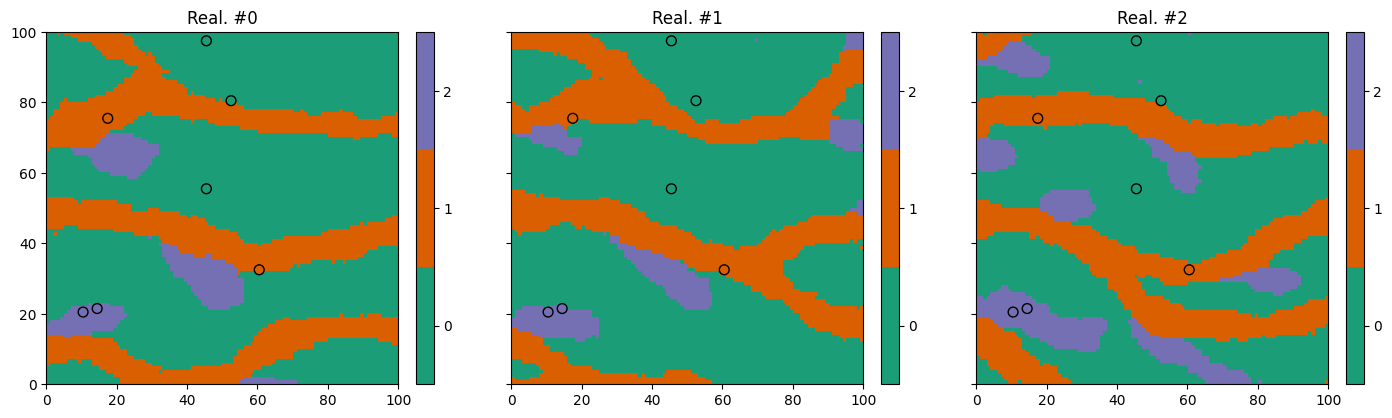

In [11]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
# -------
# Get colors for hard data (according to variable of index 3 in the point set, and color settings)
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categ_val, categCol=categ_col) 

plt.subplots(1, 3, figsize=(17,5), sharey=True)
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    
    # Plot realization #i
    gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col) 
    # Add hard data points
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', linewidths=1)
    
    plt.title(f'Real. #{i}')

plt.show()

## Do some statistics on the realizations

The function `geone.img.imageCategProp(im, categ)` allows to compute the pixel-wise proportions of given categories in the list `categ` over all the variables of the image `im`. First, an image with `nreal` variables, each one corresponding to one realization, is defined (from the array of realizations) using the function `geone.img.gatherImages`.

In [12]:
# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, categ_val)

Plot the results.

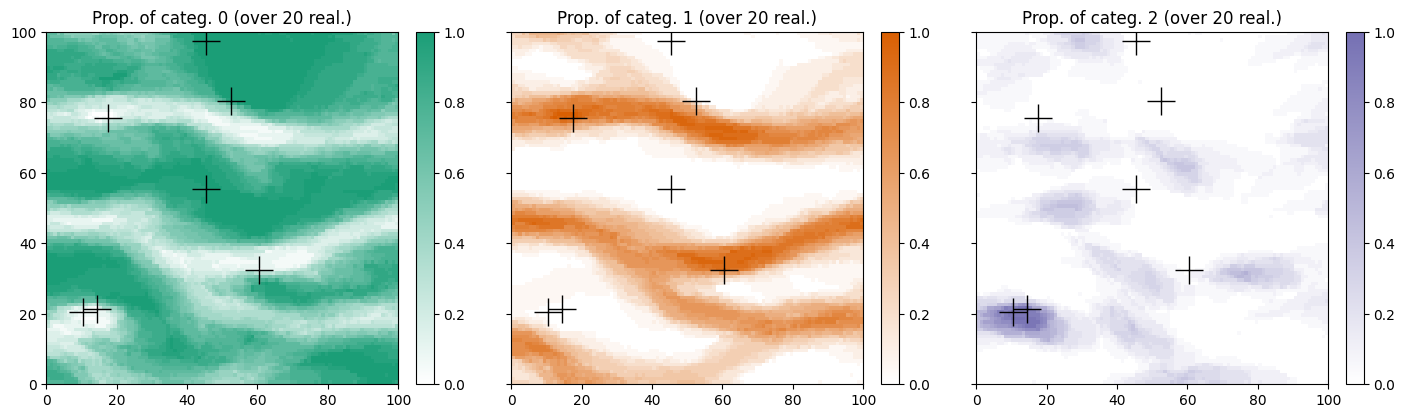

In [13]:
prop_col=['#1b9e77', '#d95f02', '#7570b3'] # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Display
plt.subplots(1, 3, figsize=(17,5), sharey=True)
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i],
                           title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points
plt.show()